# Case study of uniaxial tensile tests

This is an example of how to use ParaMaterial to process a dataset of uniaxial tensile test measurements.



## Data processing
- **Trim data.**
- **Screen trimming.**
- **Make representative curves.**

Import libraries and objects.

In [16]:
import numpy as np
import pandas as pd

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

A quick reminder of the prepared data.

In [17]:
prepared_set = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx').sort_by(['temperature', 'lot'])

styler = pam.plotting.Styler(
    color_by='temperature', cmap='plasma', cbar=True, cbar_label='Temperature (°C)',
    linestyle_by='test type', linestyle_by_label='Type',
    plot_kwargs={'grid': True}
).style_to(prepared_set)


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


# ds_plot(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.8);

We will only be processing and analysing the uniaxial tension data. We can filter the dataset as follows.

In [18]:
prepared_set = prepared_set[{'test type': ['UT']}]  # filter dataset
# ds_plot(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.8);

We want to trim the trailing data.

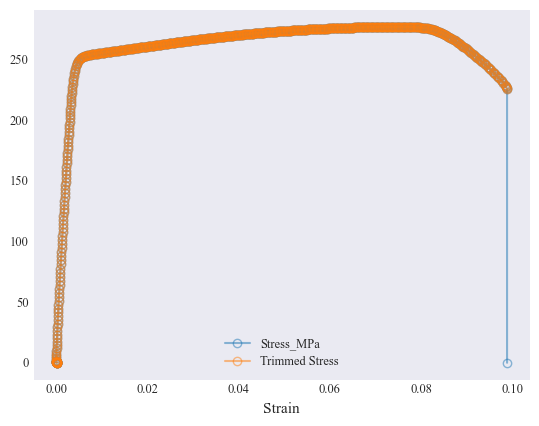

In [19]:
df = prepared_set[0].data  # get example dataitem data
ax = df.plot(x='Strain', y='Stress_MPa', marker='o', mfc='none', alpha=0.5)
# remove the last data point
df[:-1].plot(x='Strain', y='Stress_MPa', label='Trimmed Stress', marker='o', mfc='none', ax=ax, alpha=0.5);

Check if this approach works for entire dataset.

In [20]:
def trim(di: DataItem) -> DataItem:
    di.data = di.data[:-1]
    return di


trimmed_set = prepared_set.apply(trim)

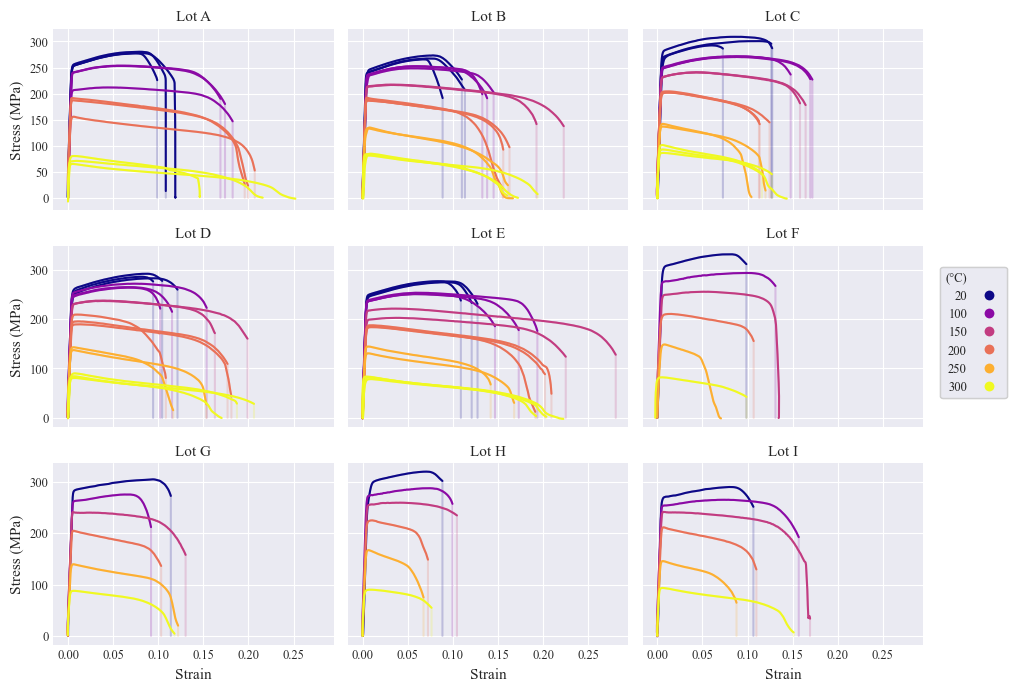

In [21]:
styler.linestyle_by = None
styler.linestyle_by_label = None
styler.color_by_label = '(°C)'
styler.cbar = False


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
        ds=ds, shape=(3, 3), sharex='all',
        styler=styler, hspace=0.2, plot_legend=False,
        rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
        cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
        plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI'],
        **kwargs
    )


axs = ds_subplots(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.2)
ds_subplots(trimmed_set, x='Strain', y='Stress_MPa', axs=axs);

The approach worked for most, but not all. We use the screening pdf to trim the remainder.

In [22]:
def screening_plot(di: DataItem) -> None:
    test_id = di.test_id
    # plot the untrimmed dataitem
    ax = ds_plot(prepared_set[{'test id': [test_id]}], x='Strain', y='Stress_MPa', alpha=0.2)
    # plot the trimmed dataitem
    ds_plot(trimmed_set[{'test id': [test_id]}], x='Strain', y='Stress_MPa', ax=ax)


# pam.processing.make_screening_pdf(trimmed_set, screening_plot, '02 trimming screening.pdf')

In [23]:
trimmed_set = pam.processing.read_screening_pdf_to(trimmed_set, '02 trimming screening marked.pdf')
trimmed_set.info_table['comment'].unique()

array(['', 'trim at 0.115', 'trim at 0.105', 'trim at 0.13',
       'trim at 0.16', 'trim at 0.18', 'trim at 0.2', 'trim at 0.14',
       'trim at 0.1', 'trim at 0.17', 'trim at 0.175', 'trim at 0.09',
       'trim at 0.11', 'trim at 0.15', 'trim at 0.05', 'trim at 0.125',
       'trim at 0.12'], dtype=object)

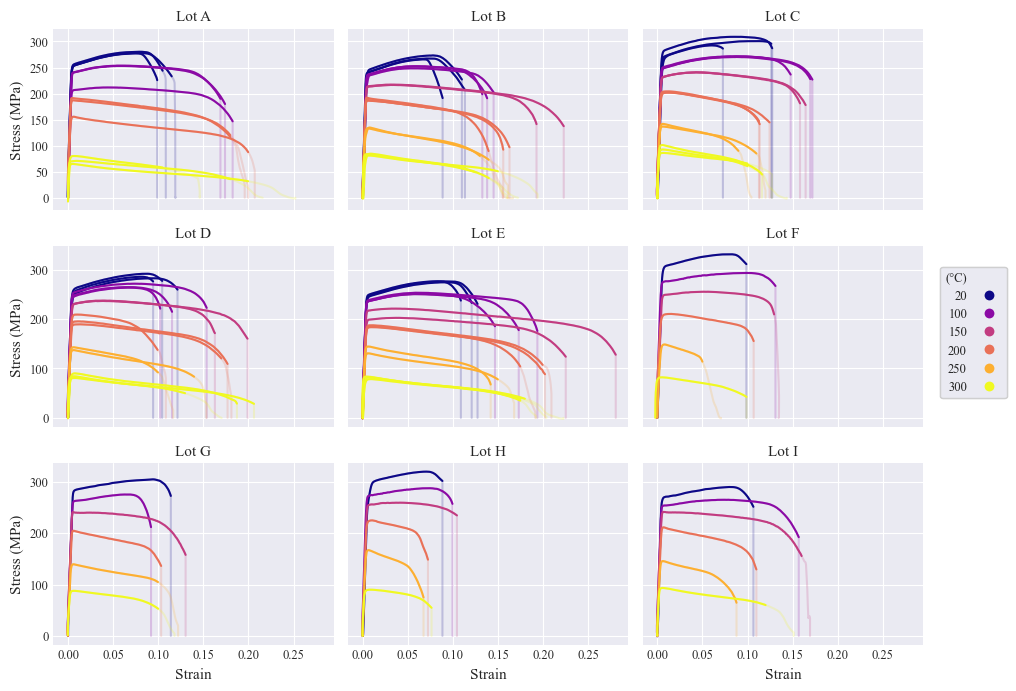

In [24]:
def screening_comment_trim(di: DataItem) -> DataItem:
    if str(di.info['comment']).startswith('trim at'):
        trim_strain = di.info['comment'].split(' ')[2]
        di.data = di.data[di.data['Strain'] <= float(trim_strain)]
        return di
    else:
        return di


trimmed_set = trimmed_set.apply(screening_comment_trim)
axs = ds_subplots(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.2)
ds_subplots(trimmed_set, x='Strain', y='Stress_MPa', axs=axs);

### Make representative curves

In [25]:
# pam.processing.make_representative_data(
#     ds=trimmed_set, data_dir='data/02 representative data', info_path='info/02 representative info.xlsx',
#     repr_col='Stress_MPa', repr_by_cols=['temperature', 'lot'], interp_by='Strain', interp_end='min_of_maxes'
# )

In [26]:
repr_set = DataSet('data/02 representative data', 'info/02 representative info.xlsx', test_id_key='repr id')

# ds_subplots(repr_set, x='interp_Strain', y='mean_Stress_MPa', fill_between=('min_Stress_MPa', 'max_Stress_MPa'), ylabel='Stress (MPa');

### Calculate force, displacement, and true stress and strain
Given engineering stress and strain.

In [27]:
def calculate_force_disp_from_eng_curve(di: DataItem) -> DataItem:
    e = di.data['Strain'].values
    s = di.data['Stress_MPa'].values
    L_0 = di.info['h_0 (mm)']
    A_0 = di.info['A_0 (mm2)']
    di.data['Displacement(mm)'] = e*L_0
    di.data['Force(kN)'] = s*A_0*0.01
    return di


processed_set = trimmed_set.apply(calculate_force_disp_from_eng_curve)

array([[<AxesSubplot:title={'center':'Lot A'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot B'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot C'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>],
       [<AxesSubplot:title={'center':'Lot D'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot E'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot F'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>],
       [<AxesSubplot:title={'center':'Lot G'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot H'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>,
        <AxesSubplot:title={'center':'Lot I'}, xlabel='Displacement(mm)', ylabel='Force (kN)'>]],
      dtype=object)

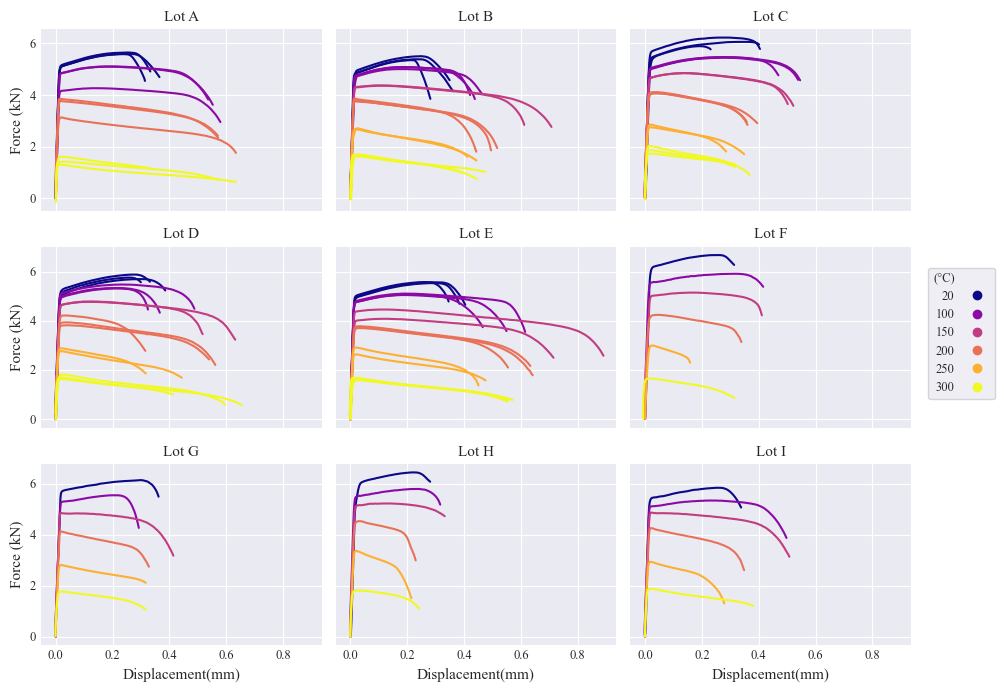

In [28]:
ds_subplots(processed_set, x='Displacement(mm)', y='Force(kN)', ylabel='Force (kN)')

In [29]:
def calculate_true_stress_strain_from_eng_curve(di: DataItem) -> DataItem:
    e = di.data['Strain'].values
    s = di.data['Stress_MPa'].values
    di.data['True Stress (MPa)'] = s*(1+e)
    di.data['True Strain'] = np.log(1 + e)
    return di


processed_set = processed_set.apply(calculate_true_stress_strain_from_eng_curve)

array([[<AxesSubplot:title={'center':'Lot A'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot B'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot C'}, xlabel='Strain', ylabel='Stress (MPa)'>],
       [<AxesSubplot:title={'center':'Lot D'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot E'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot F'}, xlabel='Strain', ylabel='Stress (MPa)'>],
       [<AxesSubplot:title={'center':'Lot G'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot H'}, xlabel='Strain', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot I'}, xlabel='Strain', ylabel='Stress (MPa)'>]],
      dtype=object)

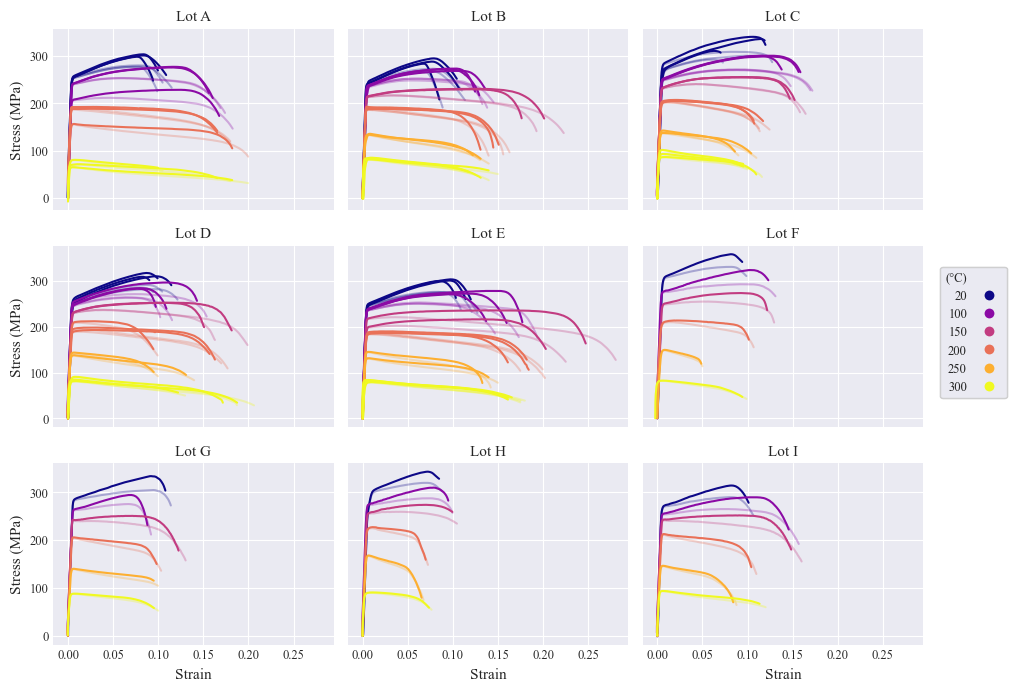

In [30]:
axs = ds_subplots(processed_set, x='Strain', y='Stress_MPa', alpha=0.3)  # engineering stress-strain
ds_subplots(processed_set, axs=axs, x='True Strain', y='True Stress (MPa)', xlabel='Strain', ylabel='Stress (MPa)');

### Write processed data

In [31]:
processed_set.write_output('data/02 processed data', 'info/02 processed info.xlsx')